In [7]:
%pip install langchain
%pip install transformers
%pip install sentence-transformers
%pip install bitsandbytes
%pip install pandas
%pip install -U langchain-community faiss-gpu langchain-openai tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.5 MB/s eta 0:00:00


In [2]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.document_loaders.merge import MergedDataLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, TokenTextSplitter, CharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain_community.vectorstores import FAISS
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import json

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [4]:
# Set seed for vector database
random.seed(42)
torch.manual_seed(42)

# Check device
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(device)

if has_gpu:
    torch.cuda.manual_seed_all(42)

cpu


In [5]:
# Extract gold labels and queries
eval_data = pd.read_csv('questions_answers.csv')
eval_data.rename(columns={eval_data.columns[0]: 'PMID'}, inplace=True)

gold_pmids = eval_data['PMID'].to_list()
eval_queries = eval_data['QUESTION'].to_list()

In [15]:
# Load embeddings
model_id = 'BAAI/bge-base-en-v1.5'
#model_id = 'llmrails/ember-v1'
#model_id = 'intfloat/e5-base-v2'

file_path = model_id.replace("/", "_")

model_kwargs = {'device': device}
encode_kwargs = {'normalize_embeddings': True}
embeddings = HuggingFaceEmbeddings(model_name=model_id, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs)

new_db = FAISS.load_local(f"faiss_indices/{model_id}", embeddings)

BAAI_bge-base-en-v1.5


In [32]:
# Compute Mean Reciprocal Rank (MRR)
retriever = new_db.as_retriever(search_type="similarity")

mrr = 0
for query, gold_label in zip(eval_queries, gold_pmids):
    top_k_results = retriever.get_relevant_documents(query)
    retrieved_pmids = [int(result.metadata['PMID']) for result in top_k_results]

    for rank, pmid in enumerate(retrieved_pmids, start=1):
        if pmid == gold_label:
            mrr += 1 / rank
            break

mrr /= len(eval_queries)
print(mrr)

# Save MRRs to a text file
with open(f"retriever_MRR_{file_path}.txt", 'w') as f:
    f.write(f"{mrr}")

0.9061876247504989


MRR interpretation: on average, the first relevant or correct answer tends to be very close to the top position in the search results

In [33]:
# Compute Normalized Discounted Cumulative Gain (nDCG)
ndcg_list = []

for k in range(1, 4):
    retriever = new_db.as_retriever(search_type="similarity", search_kwargs={"k": k})

    dcg_values = []
    for query, gold_label in zip(eval_queries, gold_pmids):
        top_k_results = retriever.get_relevant_documents(query)
        retrieved_pmids = [int(result.metadata['PMID']) for result in top_k_results]

        # DCG calculation
        dcg = sum([1 / np.log2(rank + 1) if pmid == gold_label else 0 for rank, pmid in enumerate(retrieved_pmids, start=2)])
        dcg_values.append(dcg)

    # Assuming ideal DCG (iDCG) is the best case where the first document is always relevant
    idcg = 1 / np.log2(2)  # Best case for top-1 result being relevant
    ndcg = np.mean([dcg / idcg for dcg in dcg_values])

    ndcg_list.append(ndcg)

    print(ndcg)


# Save nDCGs to a text file
with open(f"retriever_nDCG_{file_path}.txt", 'w') as f:
    for ndcg in ndcg_list:
        f.write(f"{ndcg}\n")

0.5364791916595628
0.5933654192044729
0.6088388284765709


nDCG interpretation: gradual increase in nDCG scores from k=1 to k=3 illustrates that while the very first document might not always be the most relevant, the system generally ranks highly relevant documents within the top 3 positions

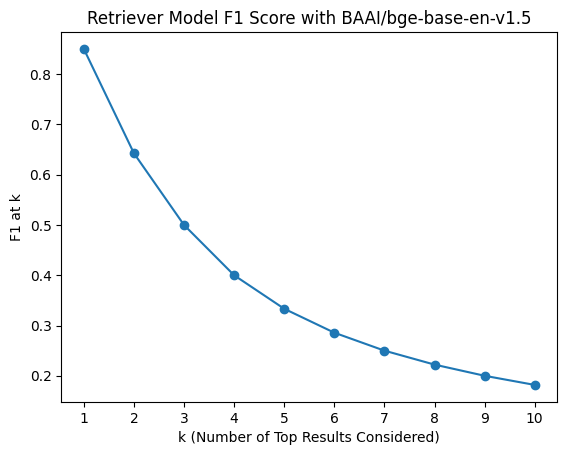

In [34]:
# Compute F1 at k
f1_list = []

for k in range(1, 11):

    precision_at_k = []
    recall_at_k = []

    for query, gold_label in zip(eval_queries, gold_pmids):
        top_k_results = retriever.get_relevant_documents(query)
        retrieved_pmids = [int(result.metadata['PMID']) for result in top_k_results[:k]]

        true_positives = sum([1 for pmid in retrieved_pmids if pmid == gold_label])
        precision = true_positives / k
        recall = true_positives / 1  #assuming one relevant document per query
        precision_at_k.append(precision)
        recall_at_k.append(recall)

    mean_precision = np.mean(precision_at_k)
    mean_recall = np.mean(recall_at_k)
    f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall) if (mean_precision + mean_recall) > 0 else 0

    f1_list.append(f1_score)


# Save F1s to a text file
with open(f"retriever_F1_{file_path}.txt", 'w') as f:
    for f1 in f1_list:
        f.write(f"{f1}\n")

# Plotting the results
plt.plot(range(1, 11), f1_list, marker='o')
plt.xlabel('k (Number of Top Results Considered)')
plt.ylabel('F1 at k')
plt.title(f'Retriever Model F1 Score with {model_id}')
plt.xticks(range(1, 11))

plt.savefig(f"retriever_f1_{file_path}.png")

F1 score interpretation: the system's ability to balance relevance (precision) with completeness (recall) diminishes as more results are considered, a common characteristic of retrieval systems, highlighting the importance of focusing on the quality of the top-ranked documents

In [35]:
# Create result tables

accuracy_path = f'retriever_accuracy_{file_path}.txt'
mrr_path = f'retriever_MRR_{file_path}.txt'
ndcg_path = f'retriever_nDCG_{file_path}.txt'
f1_path = f'retriever_F1_{file_path}.txt'


def read_file(path):
  results = []
  with open(path, 'r') as f:
    for line in f:
      results.append(round(float(line.strip()), 4))

  return results

accuracies = read_file(accuracy_path)
mrr_scores = read_file(mrr_path)
ndcg_scores = read_file(ndcg_path)
f1_scores = read_file(f1_path)

In [42]:
model_id_2 = 'llmrails/ember-v1'
file_path_2 = model_id_2.replace("/", "_")

accuracy_path_2 = f'retriever_accuracy_{file_path_2}.txt'
mrr_path_2 = f'retriever_MRR_{file_path_2}.txt'
ndcg_path_2 = f'retriever_nDCG_{file_path_2}.txt'
f1_path_2 = f'retriever_F1_{file_path_2}.txt'


def read_file(path):
  results = []
  with open(path, 'r') as f:
    for line in f:
      results.append(round(float(line.strip()), 4))

  return results

accuracies_2 = read_file(accuracy_path_2)
mrr_scores_2 = read_file(mrr_path_2)
ndcg_scores_2 = read_file(ndcg_path_2)
f1_scores_2 = read_file(f1_path_2)

In [46]:
accuracy_scores = {model_id: accuracies, model_id_2: accuracies_2,}

df_acc = pd.DataFrame(accuracy_scores).T
df_acc.columns = [f"k={i}" for i in range(1, 21)]

df_acc.reset_index(inplace=True)
df_acc.rename(columns={"index": "Model Name"}, inplace=True)

df_acc

,Model Name,k=1,k=2,k=3,k=4,k=5,k=6,k=7,k=8,k=9,...,k=11,k=12,k=13,k=14,k=15,k=16,k=17,k=18,k=19,k=20
0,llmrails/ember-v1,0.8503,0.9341,0.9581,0.9641,0.9701,0.976,0.982,0.982,0.982,...,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982,0.982
